# Part 1 from tensorflow to HLS4ML


In [1]:
import numpy as np
seed = 0
np.random.seed(seed)

import tensorflow as tf
tf.random.set_seed(seed)


import sys

sys.path.append("/home/webphy/Desktop/dnn_processor/")  # just to enable `dataset`
sys.path.append(
    "/home/webphy/Desktop/dnn_processor/dataset/"
)  # just to enable `dataset`

import dataset
import plotting
import keras

2024-02-03 09:57:21.150750: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-03 09:57:21.175003: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-03 09:57:21.175022: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-03 09:57:21.175739: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-03 09:57:21.179834: I tensorflow/core/platform/cpu_feature_guar

## Fetch the dataset


In [2]:

BATCH_SIZE = 64
train_images_rgx = "../dataset/resized_dataset_texturas_v2/*/*.jpeg"
valid_images_rgx = "../dataset/resized_dataset_texturas_v2_test/*/*.jpeg"

train_ds, val_ds, nclasses = dataset.create_datasets(
    train_images_rgx, valid_images_rgx, BATCH_SIZE
)

2024-02-03 09:57:22.435386: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-03 09:57:22.459645: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-03 09:57:22.459767: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Load the model

In [3]:


model_trial_id = 271

model = keras.models.load_model(
    f"../neural_network/automl/saved_models/striped_models/exp6_aug_calib/{model_trial_id}.h5"
)

# x = x_in = keras.layers.Input(shape=(256,256,3))
# for l in model.layers[1:]:
#     x = l(x)
#
#     if l.name == "activation_956":
#         break
# new_model = keras.models.Model(x_in, x)
# new_model.summary()

model.layers[-1].activation = keras.activations.linear
model.compile(
    "adam",
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# model.summary()
new_model = model


## Check performance

In [4]:
score = model.evaluate(val_ds)
print("Accuracy: {}".format(score[1]))

2024-02-03 09:57:25.061282: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


1/1 [==============================] - 2s 2s/step - loss: 0.2439 - accuracy: 0.9400
Accuracy: 0.9399999976158142


## Convert the model to FPGA firmware with hls4ml

### Make an hls4ml config & model

In [5]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(
    new_model,
    granularity="name",
    default_precision="fixed<4,4>",
    default_reuse_factor=2048,
    
)

config["Model"]["Strategy"] = "Resource"

for layer in config["LayerName"].keys():
    config["LayerName"][layer]["Strategy"] = "Resource"

config["LayerName"]["depthwise_conv2d_220"]["Strategy"] = "Latency"
config["LayerName"]["depthwise_conv2d_221"]["Strategy"] = "Latency"

config["LayerName"][f"dense_{model_trial_id}"]["ReuseFactor"] = 4000
config["LayerName"][f"dense_{model_trial_id}"]["Strategy"] = "Resource"


/home/webphy/Desktop/dnn_processor/.venv/lib/python3.10/site-packages/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 256, 256, 3]], output shape: [None, 256, 256, 3]
Layer name: depthwise_conv2d_220, layer type: DepthwiseConv2D, input shapes: [[None, 256, 256, 3]], output shape: [None, 85, 85, 3]
Layer name: activation_759, layer type: Activation, input shapes: [[None, 85, 85, 3]], output shape: [None, 85, 85, 3]
Layer name: conv2d_810, layer type: Conv2D, input shapes: [[None, 85, 85, 3]], output shape: [None, 41, 41, 24]
Layer name: activation_760, layer type: Activation, input shapes: [[None, 41, 41, 24]], output shape: [None, 41, 41, 24]
Layer name: depthwise_conv2d_221, layer type: DepthwiseConv2D, input shapes: [[None, 41, 41, 24]], output shape: [None, 10, 10, 24]
Layer name: activation_761, layer type: Activation, input shapes: [[None, 10, 10, 24]], output shape: [None, 10, 10, 24]
Layer name: conv2d_811, layer type: Conv2D, input shapes: [[None, 10, 10, 24]], output shape: [None, 10, 10, 40]
Layer

In [6]:
print("-----------------------------------")
print("Configuration")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    new_model,
    hls_config=config,
    output_dir=f"model_{model_trial_id}/hls4ml_prj",
    part="xc7z020-clg400-1",
    io_type="io_stream",
)

-----------------------------------
Configuration
Model
  Precision:         fixed<4,4>
  ReuseFactor:       2048
  Strategy:          Resource
  BramFactor:        1000000000
  TraceOutput:       False
LayerName
  input_1
    Trace:           False
    Precision
      result:        fixed<4,4>
    Strategy:        Resource
  depthwise_conv2d_220
    Trace:           False
    Precision
      result:        fixed<4,4>
      weight:        fixed<4,4>
      bias:          fixed<4,4>
    Strategy:        Latency
  depthwise_conv2d_220_linear
    Trace:           False
    Precision
      result:        fixed<4,4>
    Strategy:        Resource
  activation_759
    Trace:           False
    Precision
      result:        fixed<4,4>
    Strategy:        Resource
  conv2d_810
    Trace:           False
    Precision
      result:        fixed<4,4>
      weight:        fixed<4,4>
      bias:          fixed<4,4>
    Strategy:        Resource
  conv2d_810_linear
    Trace:           False
    P

Let's visualise what we created. The model architecture is shown, annotated with the shape and data types


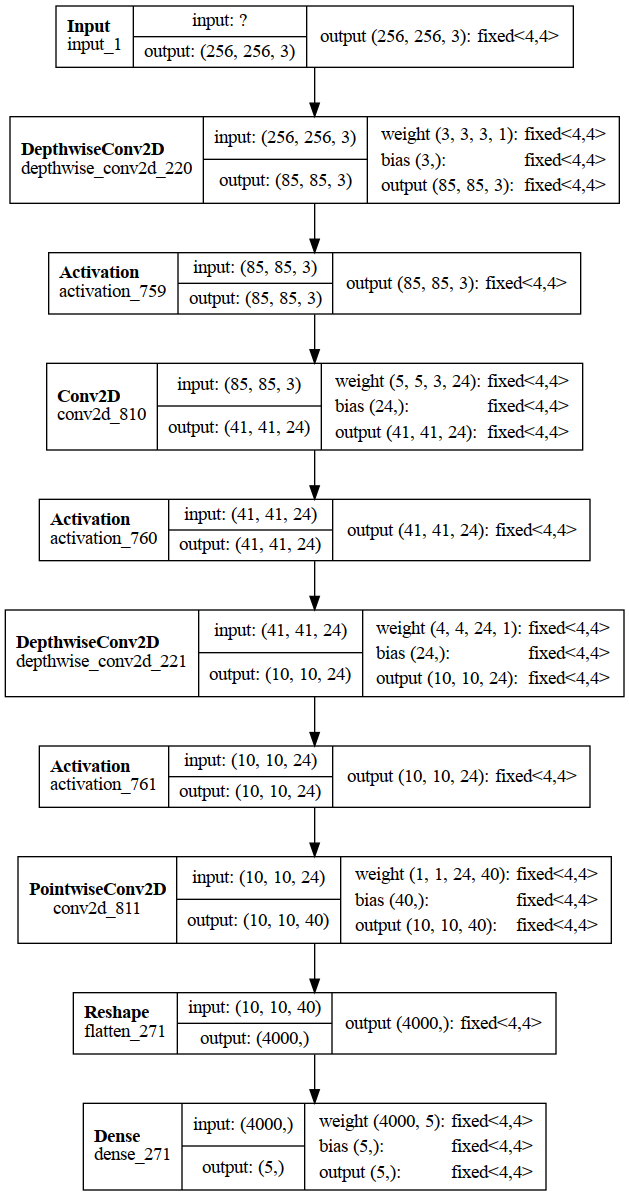

In [7]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

## Compile, predict

Now we need to check that this model performance is still good. We compile the hls_model, and then use `hls_model.predict` to execute the FPGA firmware with bit-accurate emulation on the CPU.


In [8]:
dataset__ = list(val_ds.as_numpy_iterator())
val_x = dataset__[0][0]
val_y = dataset__[0][1]

hls_model.compile()
val_ds_np = np.ascontiguousarray(val_x).astype(np.float32)
y_hls = hls_model.predict(val_ds_np)
y_hls = tf.nn.softmax(y_hls).numpy()

writing....
Writing HLS project


/home/webphy/Desktop/dnn_processor/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done
writed....
backend FPGA model_271/hls4ml_prj
trying bash build lib.sh
Ok
lib_name model_271/hls4ml_prj/firmware/myproject-9fa569b3.so
backend compiled....
compiled....


## Compare


2/2 [==============================] - 0s 40ms/step
Keras  Accuracy: 0.94
hls4ml Accuracy: 0.2


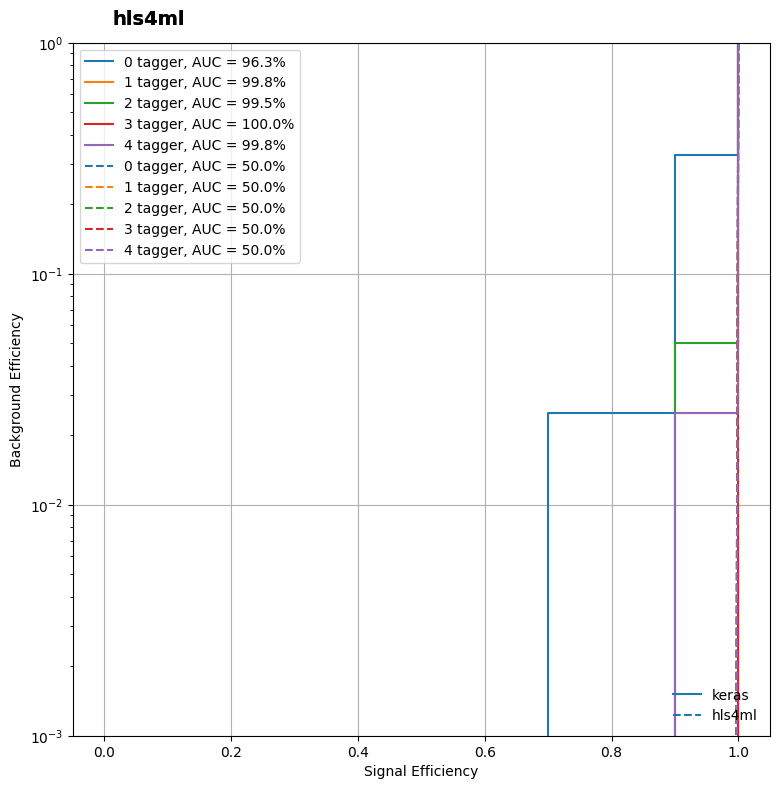

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from matplotlib.lines import Line2D
from matplotlib.legend import Legend


classes = ["0", "1", "2", "3", "4"]

y_keras = new_model.predict(val_x)
y_keras = tf.nn.softmax(y_keras, axis=-1).numpy()

print(
    "Keras  Accuracy: {}".format(
        accuracy_score(np.argmax(val_y, axis=-1), np.argmax(y_keras, axis=-1))
    )
)
print(
    "hls4ml Accuracy: {}".format(
        accuracy_score(np.argmax(val_y, axis=1), np.argmax(y_hls, axis=1))
    )
)

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(val_y, y_keras, classes)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(val_y, y_hls, classes, linestyle="--")

lines = [Line2D([0], [0], ls="-"), Line2D([0], [0], ls="--")]

leg = Legend(ax, lines, labels=["keras", "hls4ml"], loc="lower right", frameon=False)
ax.add_artist(leg)

## Synthesize

**This can take several minutes.**

In [10]:
hls_model.build(csim=False)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2020.1 (64-bit)
  **** SW Build 2902540 on Wed May 27 19:54:35 MDT 2020
  **** IP Build 2902112 on Wed May 27 22:43:36 MDT 2020
    ** Copyright 1986-2020 Xilinx, Inc. All Rights Reserved.

source /opt/Xilinx/Vivado/2020.1/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/opt/Xilinx/Vivado/2020.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'webphy' on host 'douglas-XPS-8950' (Linux_x86_64 version 6.5.0-15-generic) on Sat Feb 03 09:57:37 -03 2024
INFO: [HLS 200-10] On os Ubuntu 22.04.3 LTS
INFO: [HLS 200-10] In directory '/home/webphy/Desktop/dnn_processor/hls4ml/model_271/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/home/webphy/Desktop/dnn_processor/hls4ml/model_271/hls4ml_prj/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject.cpp' to the project
INFO: [HLS 200-10] Adding test bench file 'myproject_test.cpp' to the projec

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '6.709',
  'BestLatency': '13077396',
  'WorstLatency': '13077396',
  'IntervalMin': '131074',
  'IntervalMax': '13077252',
  'BRAM_18K': '77',
  'DSP': '0',
  'FF': '7829',
  'LUT': '22652',
  'URAM': '0',
  'AvailableBRAM_18K': '280',
  'AvailableDSP': '220',
  'AvailableFF': '106400',
  'AvailableLUT': '53200',
  'AvailableURAM': '0'}}

## Check the reports

Print out the reports generated by Vivado HLS. Pay attention to the Latency and the 'Utilization Estimates' sections


In [11]:
hls4ml.report.read_vivado_report(f"model_{model_trial_id}/hls4ml_prj/")

Found 1 solution(s) in model_271/hls4ml_prj//myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Sat Feb  3 10:00:31 2024

* Version:        2020.1 (Build 2897737 on Wed May 27 20:21:37 MDT 2020)
* Project:        myproject_prj
* Solution:       solution1
* Product family: zynq
* Target device:  xc7z020-clg400-1


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  | 5.00 ns | 6.709 ns |   0.62 ns  |
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +----------+----------+-----------+-----------+--------+----------+----------+
    |   Latency (cycles)  |   Latency (absolute)  |      Interval     | Pipeline |
    |    min   |    max   |    min    |    max    |   min  |    max   |   Type   |
    +--